# CSE 5280 Assignment: Multi-Particle Animation with Social Forces

## Overview

The previous assignment dealt with the issue of generating motion for a single particle by performing gradient descent across a cost function, where the cost of a points position was determined by its distance from the goal point as well as a penalty for being close to walls. This assignment extends this idea by allowing for multiple particles to pathfind to the goal at once, while enacting a *social force* on each other.

While called "social force", an actual physical force is not applied on the points during their gradient descent. Instead, points still use a cost-function minimization approach, with the additional complication that nearby points also contribute to the cost function for a given point.

Two types of social forces are implemented in this notebook: _symmetric social force_, which is characterized by a cost field that is only dependent on the distance from a point, and _anisotropic social force_, which is asymmetric and prioritizes cost in the direction of motion.

## Problem Description

Provided is a two-dimensional floor plan, with walls, along with a set of $N$ particles with positions

$$
\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N \in \mathbb{R}^2
$$

Each particle should move by performing gradient descent on its own cost function, which includes interations for all other particles.

Extending the cost function from the previous assignment, for a particle $i$, the total cost for the particle can be calculated using

$$
C_i(\mathbf{x}_i) = C_{goal}(\mathbf{x}_i)+C_{walls}(\mathbf{x}_i)+\sum_{\underset{j\neq i}{j=1}}^N C_{social}(\mathbf{x}_i,\mathbf{x}_j).
$$

Each particle is still updated according to the gradient descent rule shown below, where $\alpha > 0$ is the step size:

$$
\mathbf{x}_i^{(k+1)}=\mathbf{x}_i^{(k)}-\alpha\nabla_{\mathbf{x}_i}C_i
$$

## Social Force Models

The social forces implemented in this notebook are:
- Quadratic Repulsion
- Inverse-Distance Repulsion
- Anisotropic Social Force

### Quadratic Repulsion (Symmetric)

The quadratic repulsion between a particle $i$ and another particle $j$ can be modeled by the equation

$$
C_{social}(i, j)=\left\{
\begin{array}{ll}
\frac{1}{2} (R-d_{ij})^2, & d_{ij} \le R, \\
0, & d_{ij} > R,
\end{array}\right.~~~~~~~d_{ij}=\|\mathbf{x}_i-\mathbf{x}_j\|.
$$

### Inverse-Distance Repulsion (Symmetric)

The inverse-distance repulsion between a particle $i$ and another particle $j$ can be modeled by the equation

$$
C_{social}(i,j) = \frac{1}{(d_{ij}+\epsilon)^p}, ~~~~~~ p \in \{1, 2\}
$$

### Anisotropic Social Force

The anisotropic social force between a particle $I$ and another particle $j$ can be modeled by the equation

$$
C^{ani}_{social}(i,j) = \left(1+\beta~\text{max}\left(0, \hat{\mathbf{v}}_i\cdot\frac{\mathbf{x}_j-\mathbf{x}_i}{\|\mathbf{x}_j-\mathbf{x}_i\|}\right)\right)\phi(\|\mathbf{x}_j-\mathbf{x}_j\|),
$$

where $\beta \ge 0$ controls the strength of the directional bias, $\mathbf{v}_i$ denotes the current velocity (or displacement) of a particle $i$, $\hat{\mathbf{v}}_i = \mathbf{v}_i/\|\mathbf{v}_i\|$, and $\phi(d)$ is a scalar distance-based penalty function (one of the symmetric social forces described above).

In [299]:
"""
Import packages and Define Constants
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import colorsys
import random

In [300]:
"""
Utility Function Definitions
"""

def ensure_dims(arr, n_dims):
    """
    Ensures a NumPy array has the correct dimensions.
    :param arr: A given NumPy array.
    :param n_dims: The desired number of dimensions.
    :return: The provided array, with the proper number of dimensions.
    """
    arr = np.array(arr, dtype=np.float32)
    while arr.ndim < n_dims:
        arr = arr[None, :]
    return arr

def point_to_point_distance(x, y, r=1):
    """
    Calculates the distance points, or lists of points. This distance
    can be scaled by setting r.
    :param x: The first point(s) to calculate distance between
    :param y: The second point(s) to calculate distance between
    :param r: The scaling factor of the distance.
    :return: A list of distances.
    """
    x = ensure_dims(x, 2)
    y = ensure_dims(y, 2)
    diff = x[:, np.newaxis, :] - y[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    return distances * r

def random_color():
    random_shift = int(random.random() * 360)
    h, s, v = colorsys.rgb_to_hsv(1, 0, 0)

    h = (h + random_shift / 360.0) % 1.0
    r, g, b = colorsys.hsv_to_rgb(h, s, v)

    # Convert back to hex
    return "#{:02X}{:02X}{:02X}".format(
        int(r * 255),
        int(g * 255),
        int(b * 255)
    ), "#{:02X}{:02X}{:02X}".format(
        int(r * 255 * 3/8),
        int(g * 255 * 3/8),
        int(b * 255 * 3/8)
    )

def instance_around_point(center_point, r, n):
    center_point = np.array(center_point, dtype=np.float32)
    points = []
    while len(points) < n:
        x = random.random() * 2*r - r
        y = random.random() * 2*r - r
        if np.linalg.norm([x, y]) < r:
            points.append(center_point + np.array([x, y]))
    return np.array(points, dtype=np.float32)

def get_distances(points, other=None):
    if other is None:
        return point_to_point_distance(points, points)
    if len(other.shape) == 2:
        return point_to_point_distance(points, other)
    else:
        return point_to_segment_distance(points, other)


In [301]:
"""
Wall Penalty Function Definitions
"""

def point_to_segment_distance(x, segments):
    """
    Distance from point x to line segment [a, b]
    """
    x = ensure_dims(x, 2)
    segments = ensure_dims(segments, 3)
    a = segments[:, 0] # (M, 2)
    b = segments[:, 1] # (M, 2)
    v = b - a # (M, 2)
    vv = np.sum(v * v, axis=1) # (M,)

    x_exp = x[:, None, :] # (N, 1, 2)
    a_exp = a[None, :, :] # (1, M, 2)
    v_exp = v[None, :, :] # (1, M, 2)

    w = x_exp - a_exp # (N, M, 2)

    t = np.zeros(w.shape[:2], dtype=np.float32) # (N, M)
    mask = vv > 0.0

    if np.any(mask):
        t[:, mask] = (np.sum(w[:, mask] * v_exp[:, mask], axis=2) / vv[mask])

    t = np.clip(t, 0.0, 1.0)

    q = a_exp + t[:, :, None] * v_exp  # (N, M, 2)
    q[:, ~mask] = a_exp[:, ~mask]
    return np.linalg.norm(x_exp - q, axis=2)  # (N, M)

def quadratic_band_penalty(x, segments, r=1):
    d = get_distances(x, segments)
    return np.where(d <= r, 0.5 * (r - d)**2, 0.0)

def quartic_band_penalty(x, segments, r=1):
    d = get_distances(x, segments)
    return np.where(d <= r, (r - d)**4, 0.0)

def truncated_log_barrier(x, segments, r=1):
    d = get_distances(x, segments)
    return np.where(d <= r, np.log10(r/(d+1e-9)), 0.0)

def truncated_inverse_distance(x, segments, r=1):
    d = get_distances(x, segments)
    return np.where(d <= r, 1/(d+1e-3), 0.0)

def inverse_distance(x, segments, r=1):
    d = get_distances(x, segments)
    return 1/(d+1e-1)**r

In [302]:
"""
Cost Function Definitions
"""

def cost(
    points,
    walls,
    goal,
    wall_cost_function=quadratic_band_penalty,
    r=1,
    goal_distance_function=point_to_point_distance,
    goal_r=1,
    wall_weights=None,
    multi_point_cost=False,
    multi_point_cost_function=truncated_log_barrier,
    multi_point_r=1,
    multi_points=None,
    direction=None,
    beta=1
):
    """
    Calculates the cost at a given point (or list of points), given a list
    of walls, a goal function, a wall cost function, and a function that
    defines the cost of the distance from the goal.
    :param points: The point(s) to calculate cost for.
    :param walls: The walls to apply the wall_cost_function to.
    :param goal: The goal point for gradient descent.
    :param wall_cost_function: The function used to calculate the cost
        for approaching a wall.
    :param goal_distance_function: The function use to calculate the cost
        of distance from the goal.
    :param r: The scaling factor of the wall cost.
    :param goal_r: The scaling factor of the goal cost.
    :param wall_weights: The weights of individual walls.
    :return: The cost at each provided point.
    """

    wall_weights = np.array(wall_weights) if wall_weights is not None else np.ones(walls.shape[0])
    if goal is None:
        goal_distances = np.zeros(points.shape[0])
    else:
        goal_distances = goal_distance_function(goal, points, r=goal_r).reshape(-1)
    wall_costs = wall_cost_function(points, walls, r=r)

    if multi_point_cost:
        assert multi_points is not None
        multi_point_costs = multi_point_cost_function(points, multi_points, multi_point_r)
        np.fill_diagonal(multi_point_costs, 0)
        if direction is not None:
            differences = multi_points[:, None, :] - multi_points[None, :, :]
            norms = np.linalg.norm(differences, axis=2, keepdims=True)
            norms[norms == 0] = 1
            unit_differences = differences / norms
            anisotropic_costs = (1 + beta*np.maximum(0, np.sum(direction * unit_differences, axis=2)))
            multi_point_costs *= anisotropic_costs
    else:
        multi_point_costs = np.zeros((points.shape[0], points.shape[0]))

    return goal_distances + np.sum(wall_weights * wall_costs, axis=1) + np.sum(multi_point_costs, axis=1)

def cost_gradient(
    points,
    walls,
    goal,
    wall_cost_function=quadratic_band_penalty,
    goal_distance_function=point_to_point_distance,
    r=1,
    goal_r=1,
    wall_weights=None,
    delta=1e-1,
    multi_point_cost=False,
    multi_point_cost_function=truncated_log_barrier,
    multi_point_r=1,
    direction=None,
    beta=1
):
    """
    Calculates the gradient of the cost at a given point (or list of points).
    :param points: The point(s) to calculate cost for.
    :param walls: The walls to apply the wall_cost_function to.
    :param goal: The goal point for gradient descent.
    :param wall_cost_function: The function used to calculate the cost
        for approaching a wall.
    :param goal_distance_function: The function use to calculate the cost
        of distance from the goal.
    :param r: The scaling factor of the wall cost.
    :param goal_r: The scaling factor of the goal cost.
    :param wall_weights: The weights of individual walls.
    :param delta: The delta used to linearly approximate the gradient at each provided point.
    :return: The cost at each provided point.
    """
    points = ensure_dims(points, 2)
    walls = ensure_dims(walls, 3)
    points_x_delta = points + np.array([delta, 0])
    points_y_delta = points + np.array([0, delta])
    point_costs = cost(points, walls, goal, wall_cost_function, r=r, goal_r=goal_r, goal_distance_function=goal_distance_function, wall_weights=wall_weights,multi_point_cost=multi_point_cost, multi_points=points,multi_point_cost_function=multi_point_cost_function, multi_point_r=multi_point_r, direction=direction, beta=beta)
    x_delta_costs = cost(points_x_delta, walls, goal, wall_cost_function, goal_distance_function=goal_distance_function, r=r, goal_r=goal_r, wall_weights=wall_weights,multi_point_cost=multi_point_cost, multi_points=points,multi_point_cost_function=multi_point_cost_function, multi_point_r=multi_point_r, direction=direction, beta=beta)
    y_delta_costs = cost(points_y_delta, walls, goal, wall_cost_function, goal_distance_function=goal_distance_function, r=r, goal_r=goal_r, wall_weights=wall_weights,multi_point_cost=multi_point_cost, multi_points=points,multi_point_cost_function=multi_point_cost_function, multi_point_r=multi_point_r, direction=direction, beta=beta)
    x_partials = (x_delta_costs - point_costs) / delta
    y_partials = (y_delta_costs - point_costs) / delta

    gradients = np.stack([x_partials, y_partials], axis=1)
    return gradients

In [303]:
"""
Plotting Function Definitions
"""

def draw_floor_plan(
    walls,
    start=None,
    end=None,
    ax=None
):
    """
    Draws a simple plot of a provided floor plan
    :param walls: A list of walls, where each wall is provided in the form [[x1, y1], [x2, y2]]
    :param start: The starting point for the gradient descent algorithm
    :param end: The ending point for the gradient descent algorithm
    :param ax: An optional matplotlib axes object. If provided, the plot will not be automatically shown.
    :return: None
    """
    show = False
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
        show = True
    for wall in walls:
        ax.plot(wall[:, 0], wall[:, 1], color='#000000', linewidth=2, linestyle='-')
    if start is not None:
        ax.scatter(start[0], start[1], color='#00FF00')
    if end is not None:
        ax.scatter(end[0], end[1], color='#FF0000')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    if show:
        plt.show()

def plot_cost_field(
    walls,
    start,
    goal,
    cost_function=quadratic_band_penalty,
    goal_distance_function=point_to_point_distance,
    r=1,
    goal_r=1,
    resolution=32,
    vector_resolution=16,
    wall_weights=None,
    ax=None,
    show_walls=True,
    show_vectors=True
):
    show = False
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
        show = True
    x_min, x_max = 0, 10
    y_min, y_max = 0, 10
    x_space = np.linspace(x_min, x_max, resolution)
    y_space = np.linspace(y_min, y_max, resolution)
    x_mesh, y_mesh = np.meshgrid(x_space, y_space)
    cost_field_points = np.stack([x_mesh, y_mesh], axis=-1).reshape(-1, 2)
    costs = cost(cost_field_points, walls, goal, wall_cost_function=cost_function, r=r, goal_r=goal_r, goal_distance_function=goal_distance_function, wall_weights=wall_weights)
    costs = costs.reshape(resolution, resolution)
    contour = plt.contourf(x_space, y_space, costs, levels=200, cmap='plasma')
    if show_walls:
        draw_floor_plan(walls, start, goal, ax=ax)
    if show_vectors:
        x_vector_space = np.linspace(x_min, x_max, vector_resolution)
        y_vector_space = np.linspace(y_min, y_max, vector_resolution)
        x_vector_mesh, y_vector_mesh = np.meshgrid(x_vector_space, y_vector_space)
        vector_field_points = np.stack([x_vector_mesh, y_vector_mesh], axis=-1).reshape(-1, 2)
        vector_gradients = cost_gradient(vector_field_points, walls, goal, wall_cost_function=cost_function, goal_distance_function=goal_distance_function, r=r, goal_r=goal_r, wall_weights=wall_weights)
        x_gradients, y_gradients = -vector_gradients[:, 0], -vector_gradients[:, 1]
        plt.quiver(vector_field_points[:, 0], vector_field_points[:, 1], x_gradients, y_gradients, color='#FFFFFF')
    plt.colorbar(contour)
    if show:
        plt.show()

In [304]:
"""
Gradient Descent Implementation
"""

def gradient_descent(
    walls,
    start,
    goal,
    cost_function=quadratic_band_penalty,
    goal_distance_function=point_to_point_distance,
    r=1,
    goal_r=1,
    step_size=0.05,
    normalize=False,
    wall_weights=None,
    max_iterations=10000,
    multi_point_cost=False,
    multi_point_cost_function=truncated_log_barrier,
    multi_point_r=1,
    anisotropic=False,
    beta=1
):
    """
    Performs a gradient descent from a starting point to a goal point, returning
    the list of points visited to get from the start point to the goal.
    :param walls: A list of walls, where each wall is provided in the form [[x1, y1], [x2, y2]]
    :param wall_weights: A list of weights corresponding to each provided wall.
    :param start: The starting point for the gradient descent algorithm
    :param goal: The end goal for the gradient descent algorithm
    :param cost_function: The cost function to use for the walls during gradient descent
    :param r: The scaling factor for the wall cost function
    :param goal_distance_function: The cost function to use for the distance from the goal point
    :param goal_r: The scaling factor for the goal cost function
    :param step_size: How far the gradient descent algorithm should step each iteration
    :param max_iterations: The maximum number of iterations gradient descent should run
        for before "auto-failing".
    :return:
    """
    start = np.array(start, dtype=np.float32)
    goal = np.array(goal, dtype=np.float32)

    current_position = start.copy()
    current_direction = np.zeros(start.shape)
    path = [current_position.copy()]
    current_iteration = 0

    while np.linalg.norm(goal - current_position) > 0.1 and current_iteration < max_iterations:
        gradient = cost_gradient(
            current_position,
            walls,
            goal,
            cost_function,
            r=r,
            goal_r=goal_r,
            goal_distance_function=goal_distance_function,
            wall_weights=wall_weights,
            multi_point_cost=multi_point_cost,
            multi_point_cost_function=multi_point_cost_function,
            multi_point_r=multi_point_r,
            direction = None if not anisotropic else current_direction,
            beta=beta
        )
        gradient = -gradient * step_size
        if normalize:
            gradient /= np.linalg.norm(gradient, axis=1).reshape(-1, 1)
        current_position += gradient
        current_direction = gradient / np.linalg.norm(gradient, axis=1).reshape(-1, 1)
        path.append(current_position.copy())
        current_iteration += 1

    return np.array(path)

In [305]:
"""
Generate Floor Plans
"""

single_wall = (np.array([
    [[5, 2], [5, 8]]
], dtype=np.float32),
np.array([2, 2], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

baseline_floor_plan = (np.array([
    [[0, 0], [0, 10]],
    [[0, 10], [10, 10]],
    [[10, 10], [10, 0]],
    [[10, 0], [0, 0]],
    [[4, 0], [4, 7]],
    [[4, 7], [8, 7]],
    [[8, 7], [8, 3]],
], dtype=np.float32),
np.array([2, 2], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

zigzag_floor_plan = (np.array([
    [[0, 0], [0, 6]],
    [[4, 10], [10, 10]],
    [[10, 10], [10, 8]],
    [[2, 0], [0, 0]],
    [[2, 0], [2, 4]],
    [[2, 4], [4, 4]],
    [[4, 4], [4, 6]],
    [[4, 6], [6, 6]],
    [[6, 6], [6, 8]],
    [[6, 8], [10, 8]],
    [[0, 6], [2, 6]],
    [[2, 6], [2, 8]],
    [[2, 8], [4, 8]],
    [[4, 8], [4, 10]],
]),
np.array([1, 1], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

symmetric_plan = (np.array([
    [[0, 0], [0, 10]],
    [[0, 10], [10, 10]],
    [[10, 10], [10, 0]],
    [[10, 0], [0, 0]],
    [[2, 8], [8, 2]]
]),
np.array([1, 1], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

dead_end_plan = (np.array([
    [[0, 0], [0, 10]],
    [[0, 10], [10, 10]],
    [[10, 10], [10, 0]],
    [[10, 0], [0, 0]],
    [[8, 6], [6, 8]],
    [[8, 6], [4, 2]],
    [[6, 8], [2, 4]]
]),
np.array([1, 1], dtype=np.float32),
np.array([9, 9], dtype=np.float32))

## Multi-Particle Simulation

The code that follows the cell below will randomly initialize $n$ particles within a small range around the starting position. These points are all assigned the same end goal, then their positions updated using gradient descent with social forces between particles.

Below are descriptions of each of the modifiable variables that can affect the simulation:
- `RESOLUTION` - Sets the number of samples points on both the x and y axes for the sake of generating contour of the cost function. It is recommended that you leave this value at $128$. Lower values may cause the contour gradients to appear "choppy", higher values will take more computation time, but have little to no visual effect on the resulting plots.
- `VECTOR_RESOLUTION` - Sets the number of sample points on both the x and y axes for the sake of generating a vector field of the cost function. It is recommended that you leave this value at $20$. Lower values will not give a good indication of the direction of the gradient across the plot, and higher values will result in a very densely packed vector field, making the plot difficult to interpret.
- `CHOSEN_PLAN` - Sets the floor plan to plot and use for demonstration. Allowed values are:
  - `single_wall` - A floor plan with a single wall
  - `baseline_floor_plan` - A simple floor plan of a closed room with a series of walls
  - `zigzag_floor_plan` - A narrow corridor with zig-zagging walls
  - `symmetric_plan` - A floor plan where a single wall blocks the start from the goal in a symmetric fashion
  - `dead_end_plan` - A floor plan where a single dead-end hallway exists between the start and the goal
- `PENALTY_FUNCTION` - The penalty function that is used to determine the penalty for approaching walls. Allowed values are:
  - `quadratic_band_penalty`
  - `quartic_band_penalty`
  - `truncated_log_barrier`
  - `truncated_inverse_distance`
  - `reciprocal_penalty` - A custom penalty function I came up with (very simple, see function definition in cells above)
- `GOAL_DISTANCE_FUNCTION` - The function to used to determine the penalty for moving away from the goal (and thus the gain for moving towards the goal). _Should not be changed from_ `point_to_point_distance`,
- `PENALTY_RADIUS` - The radius from each wall at which the `PENALTY_FUNCTION` comes into effect. Values from $1-3$ tend to yield good results.
- `GOAL_SCALE_FACTOR` - A scale factor for the `GOAL_DISTANCE_FUNCTION`. Values from $1-3$ tend to yield good results.
- `STEP_SIZE` - The factor by which the gradients are multiplied to determine how far each point should "step" during gradient descent
- `NUM_POINTS` - The number of points to instance at the start of the simulation
- `POINT_INSTANCE_RADIUS` - The radius from the starting positions from which points should be instantiated.
- `MULTI_POINT_COST` - Whether social forces between points should be enabled. Should be left as `True`, but can be disabled if necessary.
- `MULTI_POINT_COST_FUNCTION` - The cost function to use when determining the social forces between points. Allowed values are:
  - `quadratic_band_penalty`
  - `inverse_distance`
- `MULTI_POINT_RADUIS` - The radius at which the cost for social forces begin affecting neighboring points (or in some cases, the scaling factor of the social force cost function)
- `ANISOTROPIC` - Whether anisotropic social forces should be used.
- `BETA` - The beta value associated with the anisotropic social forces (only used when `ANISOTROPIC` is set to `True`)

In [306]:
RESOLUTION = 128
VECTOR_RESOLUTION = 20

CHOSEN_PLAN = zigzag_floor_plan
PENALTY_FUNCTION = quartic_band_penalty
GOAL_DISTANCE_FUNCTION = point_to_point_distance
PENALTY_RADIUS = 1.5
GOAL_SCALE_FACTOR = 2
STEP_SIZE=0.05

NUM_POINTS = 20
POINT_INSTANCE_RADIUS = .75
MULTI_POINT_COST = True
MULTI_POINT_COST_FUNCTION = quadratic_band_penalty
MULTI_POINT_RADIUS = .2
ANISOTROPIC=False
BETA=1

In [307]:
floor_plan, start_point, end_point = CHOSEN_PLAN

## Floor Plan Visualizatoin

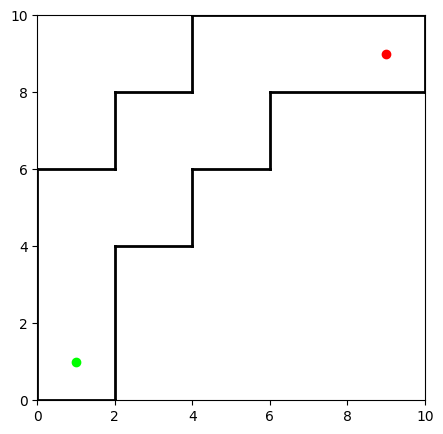

In [290]:
draw_floor_plan(floor_plan, start_point, end_point)

## Cost Field Visualization (Walls Only)

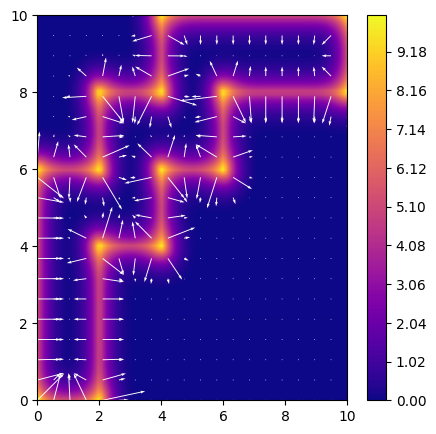

In [291]:
"""""
Visualize Cost Field
"""
plot_cost_field(
    floor_plan,
    start_point,
    None,
    cost_function=PENALTY_FUNCTION,
    goal_distance_function=GOAL_DISTANCE_FUNCTION,
    r=PENALTY_RADIUS,
    goal_r=GOAL_SCALE_FACTOR,
    resolution=RESOLUTION,
    vector_resolution=VECTOR_RESOLUTION,
    show_walls=False,
    show_vectors=True
)

## Cost Field Visualization (Walls and Goal)

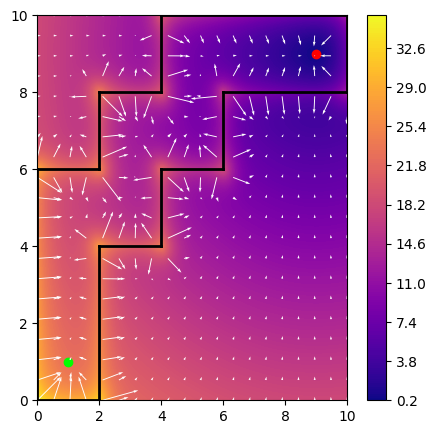

In [292]:
"""""
Visualize Cost Field
"""
plot_cost_field(
    floor_plan,
    start_point,
    end_point,
    cost_function=PENALTY_FUNCTION,
    goal_distance_function=GOAL_DISTANCE_FUNCTION,
    r=PENALTY_RADIUS,
    goal_r=GOAL_SCALE_FACTOR,
    resolution=RESOLUTION,
    vector_resolution=VECTOR_RESOLUTION,
    show_walls=True,
    show_vectors=True
)

## Gradient Descent Path Visualization

In [293]:
starting_positions = instance_around_point(start_point, POINT_INSTANCE_RADIUS, NUM_POINTS)
path = gradient_descent(
    floor_plan,
    starting_positions,
    end_point,
    cost_function=PENALTY_FUNCTION,
    goal_distance_function=GOAL_DISTANCE_FUNCTION,
    r=PENALTY_RADIUS,
    goal_r=GOAL_SCALE_FACTOR,
    multi_point_cost=MULTI_POINT_COST,
    multi_point_cost_function=MULTI_POINT_COST_FUNCTION,
    multi_point_r=MULTI_POINT_RADIUS,
    step_size=STEP_SIZE,
    anisotropic=ANISOTROPIC,
    beta=BETA
)

path_colors = []
for i in range(NUM_POINTS):
    path_colors.append(random_color())

## Visualization and Animation

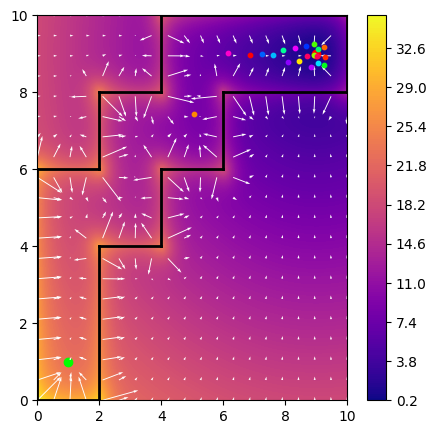

In [294]:
_, ax = plt.subplots(figsize=(5, 5))
plot_cost_field(
    floor_plan,
    start_point,
    end_point,
    PENALTY_FUNCTION,
    goal_distance_function=GOAL_DISTANCE_FUNCTION,
    r=PENALTY_RADIUS,
    goal_r=GOAL_SCALE_FACTOR,
    resolution=RESOLUTION,
    vector_resolution=VECTOR_RESOLUTION,
    ax=ax
)

timestamp = None
for i in range(NUM_POINTS):
    if timestamp is not None:
        plt.scatter(path[timestamp, i, 0], path[timestamp, i, 1], color=path_colors[i][0],s=10)
    else:
        plt.plot(path[:, i, 0], path[:, i, 1], color=path_colors[i][0], lw=1, path_effects=[pe.Stroke(linewidth=2, foreground=path_colors[i][1]), pe.Normal()])
plt.show()

Unfortunately, I ran into some issues with running some of the provided Vedo + ffmpeg + displaying video code provided.

In [297]:
start_frame=450
end_frame=600
for i in range(end_frame-start_frame):
    print(f"Processing frames... [{i+1}/{end_frame-start_frame}]", end='\r')
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_cost_field(
        floor_plan,
        start_point,
        end_point,
        PENALTY_FUNCTION,
        goal_distance_function=GOAL_DISTANCE_FUNCTION,
        r=PENALTY_RADIUS,
        goal_r=GOAL_SCALE_FACTOR,
        resolution=RESOLUTION,
        vector_resolution=VECTOR_RESOLUTION,
        ax=ax
    )
    for j in range(NUM_POINTS):
        plt.scatter(path[i+start_frame, j, 0], path[i+start_frame, j, 1], color=path_colors[j][0],s=10)
    plt.savefig('frames/{:05d}.png'.format(i+start_frame))
    plt.close()
print()

Processing frames... [150/150]


In [298]:
# import cv2
# import glob
#
# VIDEO_NAME = "alt_isotropic_inverse_distance.mp4"
#
# # Path to frames
# frame_files = sorted(glob.glob('frames/*.png'))
#
# # Read the first frame to get video dimensions
# frame = cv2.imread(frame_files[0])
# height, width, channels = frame.shape
#
# # Create a VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # mp4 codec
# out = cv2.VideoWriter(VIDEO_NAME, fourcc, 30.0, (width, height))
#
# # Write all frames to the video
# for file in frame_files:
#     frame = cv2.imread(file)
#     out.write(frame)
#
# # Release the video writer
# out.release()
# print(f"Video saved as {VIDEO_NAME}")

Video saved as alt_isotropic_inverse_distance.mp4


Isotropic Quadratic done with radius=1

Isotropic inverse distance done with p=0.4

Anisotropic Quadratic done with radius=1, beta=2

Anisotropic inverse distance done with p=0.2, beta=1

In [2]:
from IPython.display import Video
Video("isotropic_quadratic.mp4", width=600)

In [3]:
from IPython.display import Video
Video("isotropic_inverse_distance.mp4", width=600)

In [4]:
from IPython.display import Video
Video("anisotropic_quadratic.mp4", width=600)

In [5]:
from IPython.display import Video
Video("isotropic_inverse_distance.mp4", width=600)